#### About

This notebook implements the solution to the [German Tank Problem](https://en.wikipedia.org/wiki/German_tank_problem) on shared cars in Tel-Aviv, as part of the [AutoTel scheme](https://en.globes.co.il/en/article-tel-aviv-launches-car-sharing-service-1001172399).

The purpose of this notebook is to remind data professionals that sometimes even a simple 70 year old technique that can be implemented with pen and paper can get extremely good results.

In [1]:
from utils import tank               # A few helper methods to keep things tidy

import pandas as pd
import numpy as np
import random

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get a JSON with raw data

json_url = 'https://reserve.autotel.co.il/reservation/cars/ajax'
backup_path = 'data/json_example.txt'

json = tank.get_json(json_url, backup_path)

Fetching JSON from website...
Live demo jitters...
Fetched successfully!


In [3]:
# Quick look
tank.describe_data(json)

Number of cars: 229
Max car id: 271
Min car id: 1
Max-Min id: 271


In [4]:
# Inspect one parking spot
tank.find_example_spot(json)

{'id': 25023582,
 'parkingAddress': [{'languageId': 1,
   'text': 'Isaac Harif St 40, Tel Aviv-Yafo, Israel'},
  {'languageId': 0, 'text': 'אייזיק חריף 40, תל אביב יפו, ישראל'}],
 'typeId': None,
 'latitude': 32.03119,
 'longitude': 34.74735,
 'capacity': None,
 'distance': 6.8,
 'showMarker': True,
 'activeCarHere': True,
 'modelsList': [10],
 'carsList': [192],
 'inactive': False}

In [5]:
# Inspect one car
tank.find_example_car(json)

{'isCached': False,
 'cacheTime': None,
 'carId': 192,
 'nickname': '181',
 'licencePlate': '63-864-81',
 'modelId': 10,
 'colorId': 0,
 'optionList': [{'name': 'AUX input', 'typeId': 0}],
 'longitude': 34.74735,
 'latitude': 32.03119,
 'hourlyRate': 0,
 'dailyRate': 0,
 'startDate': None,
 'endDate': None,
 'distance': 6.8,
 'parkingAddress': 'Isaac Harif St 40, Tel Aviv-Yafo, Israel',
 'carCategoryId': 0,
 'carCategoryName': 'Basic / בייסיק',
 'billingCarClassId': 'C1',
 'maintenanceList': None,
 'lastOdometer': 26144,
 'lastFuelPercentage': 65,
 'address': [{'languageId': 1,
   'text': 'Isaac Harif St 40, Tel Aviv-Yafo, Israel'},
  {'languageId': 0, 'text': 'אייזיק חריף 40, תל אביב יפו, ישראל'}],
 'addressHe': 'אייזיק חריף 40, תל אביב יפו, ישראל',
 'addressEn': 'Isaac Harif St 40, Tel Aviv-Yafo, Israel',
 'discountTypeId': 0,
 'discountTypeDesc': [{'languageId': 1, 'text': ''},
  {'languageId': 0, 'text': ''}],
 'model': 'i-10',
 'manufacturer': 'Hyundai',
 'status': None,
 'color':

## Let's roll

(get it?)



# N ≈ m + (m-k) / k

where:<br>
m = largest number found<br>
k = number of 'numbers' found

In [6]:
def gen_carlist(json):
    """
    Returns a list of all car sticker ids found in the JSON.
    """
    l = []

    for i in range(len(json['cars'])):
        cars_list = json['cars'][i]['info']['carsList']
        if len(cars_list)>0:
            l.extend(cars_list)
            
    return l

        
        
def gen_mvue(sublist):
    """
    Returns the minimum-variance unbiased estimator for the number of items based on a list of observed ids in nature.
    """
    m = max(sublist)
    k = len(sublist)
    return m + float(m-k)/k



def run_seq(len_sublist, num_iter, full_list):
    """
    Runs the procedure multiple times for a sublist of given length.
    
    len_sublist: size of the sublist to fetch in each iteration
    num_iter: number of iterations to run
    full_list: full list to sample from
    """
    
    df = pd.DataFrame(columns=['len_sublist', 'mvue'])
    
    for i in range(num_iter):
        sublist = random.sample(full_list, len_sublist)
        mvue = gen_mvue(sublist)
        df.loc[i] = [len_sublist, mvue]
        
    return df



In [7]:
# Run!

l = gen_carlist(json)
dfs = []

for n in range(1,21):
    print('\rCalculalting for sublist with len: {}.'.format(n), end='')
    df = run_seq(num_iter=100, len_sublist=n, full_list=l)
    dfs.append(df)
    
full_df = pd.concat(dfs)

Calculalting for sublist with len: 20.

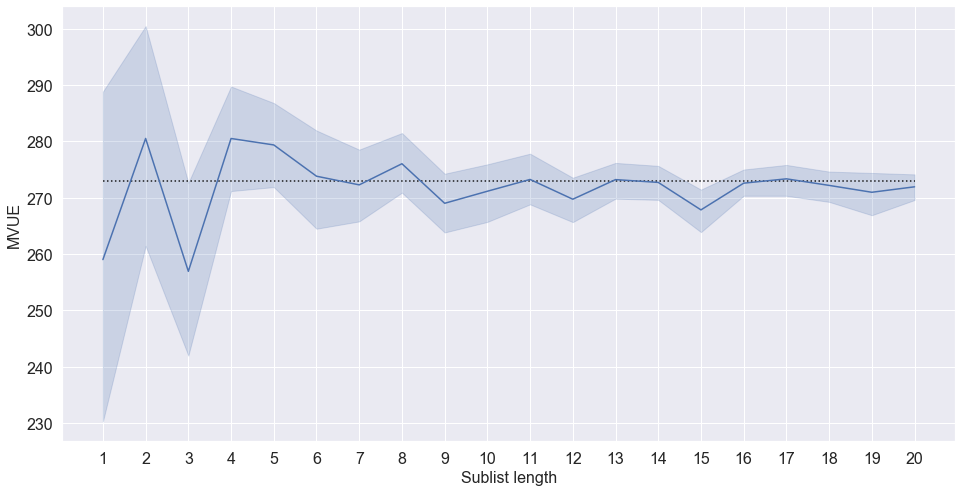

In [8]:
plt.figure(figsize=(16, 8))

sns.lineplot(x="len_sublist", y="mvue", data=full_df)

plt.hlines(y=273, xmin=1, xmax=20, linestyles='dotted')   # <=== 273 is the actual number

plt.ylabel('MVUE', fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('Sublist length', fontsize=16)
plt.xticks(range(1,21), fontsize=16);

Notes:
- The actual number is 273.
- Arguably a more accurate approach would have been to ping the AutoTel website and grab a json for each iteration inspected. This is impractical for several reasons, one of them is that the data set takes long to change (as cars actually have to move).


In [9]:
full_df['mvue'].max()

541.0

In [10]:
full_df.head()

,len_sublist,mvue
0,1.0,77.0
1,1.0,221.0
2,1.0,207.0
3,1.0,383.0
4,1.0,147.0


In [15]:
round(pd.pivot_table(full_df, index='len_sublist', values='mvue', aggfunc=np.mean),2)

,mvue
len_sublist,
1.0,259.02
2.0,280.52
3.0,256.93
4.0,280.51
5.0,279.37
6.0,273.82
7.0,272.28
8.0,276.03
9.0,269.01


---

#### Bonus content

Bayesian approaches ([wikipedia](https://en.wikipedia.org/wiki/German_tank_problem#Bayesian_analysis)) seem to be doing a fair job, but require a larger sample sizes to stabilise. 


In [23]:
def go_bayes(l, k):
    sl = random.sample(l, k)
    m = max(sl)
    sigma = (((k-1)*(m-1)*(m-k+1))/((k-3)*(k-2)**2))**.5
    miu = (m-1)*(k-1)/(k-2)
    print("{}-{}".format(round(miu-sigma), round(miu+sigma)))
    
    
go_bayes(l, 50)

268-279


In [24]:
from math import log


def go_bayes_median(l, k):
    sl = random.sample(l, k)
    m = max(sl)
    n = m + m*log(2)/(k-1)
    print(round(n))

    
go_bayes_median(l, 25)

278
